### Installation

In [ ]:
%%capture
import os, re
if "COLAB_" not in "".join(os.environ.keys()):
    !pip install unsloth
else:
    # Do this only in Colab notebooks! Otherwise use pip install unsloth
    import torch; v = re.match(r"[0-9]{1,}\.[0-9]{1,}", str(torch.__version__)).group(0)
    xformers = "xformers==" + ("0.0.33.post1" if v=="2.9" else "0.0.32.post2" if v=="2.8" else "0.0.29.post3")
    !pip install --no-deps bitsandbytes accelerate {xformers} peft trl triton cut_cross_entropy unsloth_zoo
    !pip install sentencepiece protobuf "datasets==4.3.0" "huggingface_hub>=0.34.0" hf_transfer
    !pip install --no-deps unsloth
!pip install transformers==4.57.1
!pip install --no-deps trl==0.22.2

### Unsloth

In [ ]:
from unsloth import FastVisionModel # FastLanguageModel for LLMs
import torch

# 4bit pre quantized models we support for 4x faster downloading + no OOMs.
fourbit_models = [
    "unsloth/Llama-3.2-11B-Vision-Instruct-bnb-4bit", # Llama 3.2 vision support
    "unsloth/Llama-3.2-11B-Vision-bnb-4bit",
    "unsloth/Llama-3.2-90B-Vision-Instruct-bnb-4bit", # Can fit in a 80GB card!
    "unsloth/Llama-3.2-90B-Vision-bnb-4bit",

    "unsloth/Pixtral-12B-2409-bnb-4bit",              # Pixtral fits in 16GB!
    "unsloth/Pixtral-12B-Base-2409-bnb-4bit",         # Pixtral base model

    "unsloth/Qwen2-VL-2B-Instruct-bnb-4bit",          # Qwen2 VL support
    "unsloth/Qwen2-VL-7B-Instruct-bnb-4bit",
    "unsloth/Qwen2-VL-72B-Instruct-bnb-4bit",

    "unsloth/llava-v1.6-mistral-7b-hf-bnb-4bit",      # Any Llava variant works!
    "unsloth/llava-1.5-7b-hf-bnb-4bit",
] # More models at https://huggingface.co/unsloth

model, tokenizer = FastVisionModel.from_pretrained(
    "unsloth/Qwen3-VL-8B-Instruct-unsloth-bnb-4bit",
    load_in_4bit = True, # Use 4bit to reduce memory use. False for 16bit LoRA.
    use_gradient_checkpointing = "unsloth", # True or "unsloth" for long context
)

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!
==((====))==  Unsloth 2025.11.4: Fast Qwen3_Vl patching. Transformers: 4.57.1.
   \\   /|    NVIDIA A100-SXM4-40GB. Num GPUs = 1. Max memory: 39.557 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.9.0+cu126. CUDA: 8.0. CUDA Toolkit: 12.6. Triton: 3.5.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.33.post1. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


model.safetensors.index.json: 0.00B [00:00, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/2.72G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/213 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/782 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json:   0%|          | 0.00/11.4M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/707 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/614 [00:00<?, ?B/s]

chat_template.jinja: 0.00B [00:00, ?B/s]

video_preprocessor_config.json:   0%|          | 0.00/817 [00:00<?, ?B/s]

We now add LoRA adapters for parameter efficient finetuning - this allows us to only efficiently train 1% of all parameters.

**[NEW]** We also support finetuning ONLY the vision part of the model, or ONLY the language part. Or you can select both! You can also select to finetune the attention or the MLP layers!

In [ ]:
model = FastVisionModel.get_peft_model(
    model,
    finetune_vision_layers     = True, # False if not finetuning vision layers
    finetune_language_layers   = True, # False if not finetuning language layers
    finetune_attention_modules = True, # False if not finetuning attention layers
    finetune_mlp_modules       = True, # False if not finetuning MLP layers

    r = 16,           # The larger, the higher the accuracy, but might overfit
    lora_alpha = 16,  # Recommended alpha == r at least
    lora_dropout = 0,
    bias = "none",
    random_state = 3407,
    use_rslora = False,  # We support rank stabilized LoRA
    loftq_config = None, # And LoftQ
    # target_modules = "all-linear", # Optional now! Can specify a list if needed
)

In [ ]:
from datasets import load_dataset

dataset = load_dataset("Adyakanta/train_flickr30k", split="test")



# Remove the specified columns
dataset = dataset.remove_columns(['sentids', 'split', 'img_id', 'filename'])

README.md:   0%|          | 0.00/471 [00:00<?, ?B/s]

data/test-00000-of-00006.parquet:   0%|          | 0.00/482M [00:00<?, ?B/s]

data/test-00001-of-00006.parquet:   0%|          | 0.00/483M [00:00<?, ?B/s]

data/test-00002-of-00006.parquet:   0%|          | 0.00/485M [00:00<?, ?B/s]

data/test-00003-of-00006.parquet:   0%|          | 0.00/485M [00:00<?, ?B/s]

data/test-00004-of-00006.parquet:   0%|          | 0.00/485M [00:00<?, ?B/s]

data/test-00005-of-00006.parquet:   0%|          | 0.00/487M [00:00<?, ?B/s]

Generating test split:   0%|          | 0/21000 [00:00<?, ? examples/s]

Let's take an overview look at the dataset. We shall see what the 3rd image is, and what caption it had.

In [ ]:
dataset

Dataset({
    features: ['image', 'caption'],
    num_rows: 21000
})

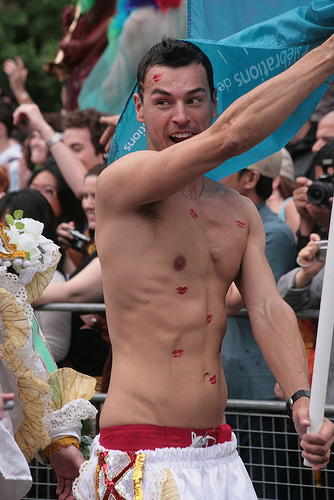

In [ ]:
dataset["image"][1]

In [ ]:
dataset["caption"][1]

['A man with several red marks on his body is holding a flag while people in the background are cheering',
 'A shirtless man covered in red lipstick kisses waving a blue flag.',
 'A shirtless man with red paint on his torso holding a stick.',
 'A man is shirtless and is covered in red marks.',
 'A shirtless man waaves a flag.']

To format the dataset, all vision finetuning tasks should be formatted as follows:

```python
[
{ "role": "user",
  "content": [{"type": "text",  "text": Q}, {"type": "image", "image": image} ]
},
{ "role": "assistant",
  "content": [{"type": "text",  "text": A} ]
},
]
```

In [ ]:
instruction = "Write a descriptive caption for this image."

def convert_to_conversation(sample):
    conversation = [
        { "role": "user",
          "content" : [
            {"type" : "text",  "text"  : instruction},
            {"type" : "image", "image" : sample["image"]}
          ]
        },
        { "role" : "assistant",
          "content" : [
            {"type" : "text",  "text"  : sample["caption"]} # Use "caption" instead of "text"
          ]
        },
    ]
    return { "messages" : conversation }

Let's convert the dataset into the "correct" format for finetuning:

In [ ]:
converted_dataset = [convert_to_conversation(sample) for sample in dataset]
# converted_dataset = dataset.map(convert_to_conversation)

In [ ]:
len(converted_dataset)

21000

We look at how the conversations are structured for the first example:

In [ ]:
converted_dataset[0]

{'messages': [{'role': 'user',
   'content': [{'type': 'text',
     'text': 'Write a descriptive caption for this image.'},
    {'type': 'image',
     'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x333>}]},
  {'role': 'assistant',
   'content': [{'type': 'text',
     'text': ['A blond man with a ponytail and straw hat is walking on a busy road in a city, passing by some plants for sale.',
      'A man with a ponytail wearing a hat walking down the street carrying a plastic bag.',
      'He is coming from the market with a bag full of fruits.',
      'Woman at a plant nursery in a coat and straw hat.',
      'A man in a hat is walking in a parking lot.']}]}]}

Let's first see before we do any finetuning what the model outputs for the first example!

In [ ]:
# FastVisionModel.for_inference(model) # Enable for inference!

# image = dataset[2]["image"]
# instruction = "Write the LaTeX representation for this image."

# messages = [
#     {"role": "user", "content": [
#         {"type": "image"},
#         {"type": "text", "text": instruction}
#     ]}
# ]
# input_text = tokenizer.apply_chat_template(messages, add_generation_prompt = True)
# inputs = tokenizer(
#     image,
#     input_text,
#     add_special_tokens = False,
#     return_tensors = "pt",
# ).to("cuda")

# from transformers import TextStreamer
# text_streamer = TextStreamer(tokenizer, skip_prompt = True)
# _ = model.generate(**inputs, streamer = text_streamer, max_new_tokens = 128,
#                    use_cache = True, temperature = 1.5, min_p = 0.1)

 $$H ^ { \prime } = \beta N \int d \lambda \left\{ \frac { 1 } { 2 \beta ^ { 2 } N ^ { 2 } } \partial _ { \lambda } \zeta ^ { \dagger } \partial _ { \lambda } \zeta + V ( \lambda ) \zeta ^ { \dagger } \zeta \right\} .$$<|im_end|>


<a name="Train"></a>
### Train the model
Now let's train our model. We do 60 steps to speed things up, but you can set `num_train_epochs=1` for a full run, and turn off `max_steps=None`. We also support TRL's `DPOTrainer`!

We use our new `UnslothVisionDataCollator` which will help in our vision finetuning setup.

In [ ]:
from unsloth import is_bf16_supported
from unsloth.trainer import UnslothVisionDataCollator
from trl import SFTTrainer, SFTConfig

FastVisionModel.for_training(model) # Enable for training!

trainer = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    data_collator = UnslothVisionDataCollator(model, tokenizer), # Must use!
    train_dataset = converted_dataset,
    args = SFTConfig(
        per_device_train_batch_size = 2,
        gradient_accumulation_steps = 4,
        warmup_steps = 5,
        # max_steps = 30,
        num_train_epochs = 1, # Set this instead of max_steps for full training runs
        learning_rate = 2e-4,
        fp16 = not is_bf16_supported(),
        bf16 = is_bf16_supported(),
        logging_steps = 1,
        optim = "adamw_8bit",
        weight_decay = 0.01,
        lr_scheduler_type = "linear",
        seed = 3407,
        output_dir = "outputs",
        report_to = "wandb",     # For Weights and Biases

        # You MUST put the below items for vision finetuning:
        remove_unused_columns = False,
        dataset_text_field = "",
        dataset_kwargs = {"skip_prepare_dataset": True},
        dataset_num_proc = 4,
        max_seq_length = 2048,
    ),
)

Unsloth: Model does not have a default image size - using 512


In [ ]:
# @title Show current memory stats
gpu_stats = torch.cuda.get_device_properties(0)
start_gpu_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
max_memory = round(gpu_stats.total_memory / 1024 / 1024 / 1024, 3)
print(f"GPU = {gpu_stats.name}. Max memory = {max_memory} GB.")
print(f"{start_gpu_memory} GB of memory reserved.")

GPU = NVIDIA A100-SXM4-40GB. Max memory = 39.557 GB.
8.273 GB of memory reserved.


In [ ]:
trainer_stats = trainer.train()

The model is already on multiple devices. Skipping the move to device specified in `args`.
==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 21,000 | Num Epochs = 1 | Total steps = 2,625
O^O/ \_/ \    Batch size per device = 2 | Gradient accumulation steps = 4
\        /    Data Parallel GPUs = 1 | Total batch size (2 x 4 x 1) = 8
 "-____-"     Trainable parameters = 51,346,944 of 8,818,470,640 (0.58% trained)
/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WA

wandb: Detected [huggingface_hub.inference, openai] in use.
wandb: Use W&B Weave for improved LLM call tracing. Install Weave with `pip install weave` then add `import weave` to the top of your script.
wandb: For more information, check out the docs at: https://weave-docs.wandb.ai/


Unsloth: Will smartly offload gradients to save VRAM!


Step,Training Loss
1,2.875000
2,2.836300
3,3.027500
4,2.994000
5,2.553000
6,2.382800
7,2.209900
8,1.972200
9,1.770100
10,1.707300


train/epoch,▁▁▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇▇██
train/global_step,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▄▄▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇█
train/grad_norm,▄▂▂▄▃▂▁▆▅▃▄▅▃▂█▂▃▃▂▄▄▅▄▃▇▃▂▄▅▃▄▇▇▄▅▅▅▇▅▆
train/learning_rate,████▇▇▇▇▇▆▆▆▆▆▆▅▅▅▅▅▄▄▄▄▄▄▄▄▄▃▃▃▃▂▂▂▂▁▁▁
train/loss,▃▇▃▅▂▄▅▄▃▄▁▂▂▆▆▃█▄▁▅▃▃▂▆▄▅▂▅▁▃▃▄▄▃▇▅▅▃▆▄
total_flos,2.9553784816030675e+17
train/epoch,1
train/global_step,2625
train/grad_norm,0.27904
train/learning_rate,0.0
train/loss,1.1241


In [ ]:
# @title Show final memory and time stats
used_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
used_memory_for_lora = round(used_memory - start_gpu_memory, 3)
used_percentage = round(used_memory / max_memory * 100, 3)
lora_percentage = round(used_memory_for_lora / max_memory * 100, 3)
print(f"{trainer_stats.metrics['train_runtime']} seconds used for training.")
print(
    f"{round(trainer_stats.metrics['train_runtime']/60, 2)} minutes used for training."
)
print(f"Peak reserved memory = {used_memory} GB.")
print(f"Peak reserved memory for training = {used_memory_for_lora} GB.")
print(f"Peak reserved memory % of max memory = {used_percentage} %.")
print(f"Peak reserved memory for training % of max memory = {lora_percentage} %.")

9481.3126 seconds used for training.
158.02 minutes used for training.
Peak reserved memory = 8.273 GB.
Peak reserved memory for training = 0.0 GB.
Peak reserved memory % of max memory = 20.914 %.
Peak reserved memory for training % of max memory = 0.0 %.


<a name="Save"></a>
### Saving, loading finetuned models
To save the final model as LoRA adapters, either use Huggingface's `push_to_hub` for an online save or `save_pretrained` for a local save.

**[NOTE]** This ONLY saves the LoRA adapters, and not the full model. To save to 16bit or GGUF, scroll down!

In [ ]:
# model.save_pretrained("lora_model")  # Local saving
# tokenizer.save_pretrained("lora_model")
from huggingface_hub import login
model.push_to_hub("Adyakanta/qwen3_finetuned_adapters_1", token = " ") # Online saving
tokenizer.push_to_hub("Adyakanta/qwen3_finetuned_adapters_1", token = " ") # Online saving

README.md:   0%|          | 0.00/618 [00:00<?, ?B/s]

Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ...adapter_model.safetensors:  20%|##        | 41.9MB /  205MB            

Saved model to https://huggingface.co/Adyakanta/qwen3_finetuned_adapters_1


Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ...mpptm90eix/tokenizer.json: 100%|##########| 11.4MB / 11.4MB            

  ...mpptm90eix/tokenizer.json: 100%|##########| 11.4MB / 11.4MB            

Now if you want to load the LoRA adapters we just saved for inference, set `False` to `True`:

### Saving to float16 for VLLM

We also support saving to `float16` directly. Select `merged_16bit` for float16. Use `push_to_hub_merged` to upload to your Hugging Face account! You can go to https://huggingface.co/settings/tokens for your personal tokens.

In [ ]:
# Select ONLY 1 to save! (Both not needed!)

# Save locally to 16bit
if True: model.save_pretrained_merged("qwen3_finetuned", tokenizer,)

# To export and save to your Hugging Face account
if True: model.push_to_hub_merged("Adyakanta/qwen3_finetuned", tokenizer, token = " ")

Found HuggingFace hub cache directory: /root/.cache/huggingface/hub
Checking cache directory for required files...
Cache check failed: model-00001-of-00004.safetensors not found in local cache.
Not all required files found in cache. Will proceed with downloading.
Checking cache directory for required files...
Cache check failed: tokenizer.model not found in local cache.
Not all required files found in cache. Will proceed with downloading.


Unsloth: Preparing safetensor model files: 100%|██████████| 4/4 [00:00<00:00, 14230.04it/s]


Note: tokenizer.model not found (this is OK for non-SentencePiece models)


Unsloth: Merging weights into 16bit: 100%|██████████| 4/4 [01:01<00:00, 15.35s/it]


Unsloth: Merge process complete. Saved to `/content/qwen3_finetuned`


Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ..._finetuned/tokenizer.json: 100%|##########| 11.4MB / 11.4MB            

Found HuggingFace hub cache directory: /root/.cache/huggingface/hub


model.safetensors.index.json: 0.00B [00:00, ?B/s]

Checking cache directory for required files...
Cache check failed: model-00001-of-00004.safetensors not found in local cache.
Not all required files found in cache. Will proceed with downloading.
Checking cache directory for required files...
Cache check failed: tokenizer.model not found in local cache.
Not all required files found in cache. Will proceed with downloading.


Unsloth: Preparing safetensor model files:   0%|          | 0/4 [00:00<?, ?it/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/4.90G [00:00<?, ?B/s]

Unsloth: Preparing safetensor model files:  25%|██▌       | 1/4 [00:33<01:41, 33.91s/it]

model-00002-of-00004.safetensors:   0%|          | 0.00/4.92G [00:00<?, ?B/s]

Unsloth: Preparing safetensor model files:  50%|█████     | 2/4 [01:37<01:42, 51.27s/it]

model-00003-of-00004.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

Unsloth: Preparing safetensor model files:  75%|███████▌  | 3/4 [04:28<01:46, 106.14s/it]

model-00004-of-00004.safetensors:   0%|          | 0.00/2.72G [00:00<?, ?B/s]

Unsloth: Preparing safetensor model files: 100%|██████████| 4/4 [07:29<00:00, 112.37s/it]


Note: tokenizer.model not found (this is OK for non-SentencePiece models)


Unsloth: Merging weights into 16bit:   0%|          | 0/4 [00:00<?, ?it/s]

Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ...0001-of-00004.safetensors:   1%|1         | 50.3MB / 4.90GB            

Unsloth: Merging weights into 16bit:  25%|██▌       | 1/4 [01:14<03:43, 74.64s/it]

Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ...0002-of-00004.safetensors:   0%|          | 2.40MB / 4.92GB            

Unsloth: Merging weights into 16bit:  50%|█████     | 2/4 [02:29<02:29, 74.64s/it]

Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ...0003-of-00004.safetensors:   0%|          | 4.21MB / 5.00GB            

Unsloth: Merging weights into 16bit:  75%|███████▌  | 3/4 [03:45<01:15, 75.33s/it]

Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ...0004-of-00004.safetensors:   1%|1         | 33.5MB / 2.72GB            

Unsloth: Merging weights into 16bit: 100%|██████████| 4/4 [04:20<00:00, 65.07s/it]


Unsloth: Merge process complete. Saved to `/content/Adyakanta/qwen3_finetuned`


In [ ]:
from IPython.display import Javascript

def shutdown_colab():
    display(Javascript('''
        google.colab.kernel.disconnect();
    '''))

shutdown_colab()

<IPython.core.display.Javascript object>

### GGUF / llama.cpp Conversion
To save to `GGUF` / `llama.cpp`, we support it natively now! We clone `llama.cpp` and we default save it to `q8_0`. We allow all methods like `q4_k_m`. Use `save_pretrained_gguf` for local saving and `push_to_hub_gguf` for uploading to HF.

Some supported quant methods (full list on our [Wiki page](https://github.com/unslothai/unsloth/wiki#gguf-quantization-options)):
* `q8_0` - Fast conversion. High resource use, but generally acceptable.
* `q4_k_m` - Recommended. Uses Q6_K for half of the attention.wv and feed_forward.w2 tensors, else Q4_K.
* `q5_k_m` - Recommended. Uses Q6_K for half of the attention.wv and feed_forward.w2 tensors, else Q5_K.

[**NEW**] To finetune and auto export to Ollama, try our [Ollama notebook](https://colab.research.google.com/github/unslothai/notebooks/blob/main/nb/Llama3_(8B)-Ollama.ipynb)

In [ ]:
# # Save to 8bit Q8_0
# if False: model.save_pretrained_gguf("unsloth_finetune", tokenizer,)
# # Remember to go to https://huggingface.co/settings/tokens for a token!
# # And change hf to your username!
# if False: model.push_to_hub_gguf("hf/unsloth_finetune", tokenizer, token = "")

# # Save to 16bit GGUF
# if False: model.save_pretrained_gguf("unsloth_finetune", tokenizer, quantization_method = "f16")
# if False: model.push_to_hub_gguf("hf/unsloth_finetune", tokenizer, quantization_method = "f16", token = "")

# # Save to q4_k_m GGUF
# if False: model.save_pretrained_gguf("unsloth_finetune", tokenizer, quantization_method = "q4_k_m")
# if False: model.push_to_hub_gguf("hf/unsloth_finetune", tokenizer, quantization_method = "q4_k_m", token = "")

# # Save to multiple GGUF options - much faster if you want multiple!
# if False:
#     model.push_to_hub_gguf(
#         "hf/unsloth_finetune", # Change hf to your username!
#         tokenizer,
#         quantization_method = ["q4_k_m", "q8_0", "q5_k_m",],
#         token = "",
#     )